#Employee Atrition Prediction

Importing various dependencies/libraries

In [95]:
import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [96]:
#importing machine learning models/gradient boosting algorithms
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

#importing evaluation mtrices
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

In [97]:
#importing the employee dataset
ibm_df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv')
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in ibm_df.columns:
    obs = ibm_df[col].size
    p_nan = round(ibm_df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({ibm_df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

numerical.remove('EmployeeCount')
numerical.remove('StandardHours')
pd.set_option('display.max_columns', 100)

In [98]:
#viewing the dataframe
display(ibm_df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


#Data Exploration and Analysis

In [99]:
print('Number of rows in the dataset: ' , ibm_df.shape[0])
print('Number of columns in the dataset: ' , ibm_df.shape[1])

Number of rows in the dataset:  1470
Number of columns in the dataset:  35


In [100]:
x = 1
print("Below is the list of columns:")
for y in ibm_df.columns:
    print(x, y)
    x = x+1

Below is the list of columns:
1 Age
2 Attrition
3 BusinessTravel
4 DailyRate
5 Department
6 DistanceFromHome
7 Education
8 EducationField
9 EmployeeCount
10 EmployeeNumber
11 EnvironmentSatisfaction
12 Gender
13 HourlyRate
14 JobInvolvement
15 JobLevel
16 JobRole
17 JobSatisfaction
18 MaritalStatus
19 MonthlyIncome
20 MonthlyRate
21 NumCompaniesWorked
22 Over18
23 OverTime
24 PercentSalaryHike
25 PerformanceRating
26 RelationshipSatisfaction
27 StandardHours
28 StockOptionLevel
29 TotalWorkingYears
30 TrainingTimesLastYear
31 WorkLifeBalance
32 YearsAtCompany
33 YearsInCurrentRole
34 YearsSinceLastPromotion
35 YearsWithCurrManager


In [101]:
ibm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [102]:
cat_columns = []
for column in ibm_df.columns:
    if ibm_df[column].dtype == 'object' and len(ibm_df[column].unique()) <=40:
        cat_columns.append(column)
    
print(cat_columns)

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


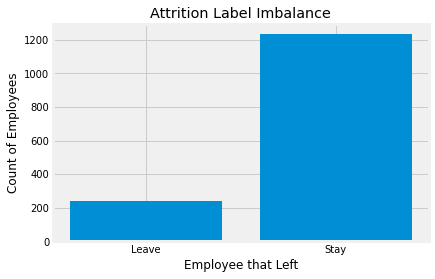

In [103]:
count_yes = ibm_df.Attrition[ibm_df.Attrition == 'Yes'].size
count_no = ibm_df.Attrition[ibm_df.Attrition == 'No'].size

plt.bar(['Leave', 'Stay'], [count_yes, count_no])
plt.title('Attrition Label Imbalance')
plt.xlabel('Employee that Left')
plt.ylabel('Count of Employees')
plt.show()

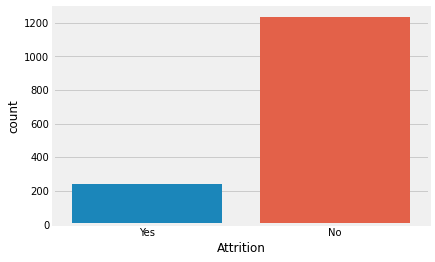

In [104]:
import plotly.express as px
fig_claim = sns.countplot(x="Attrition",data=ibm_df)
plt.show()

In [105]:
#checking for empty entries
ibm_df.isnull().sum().any()

False

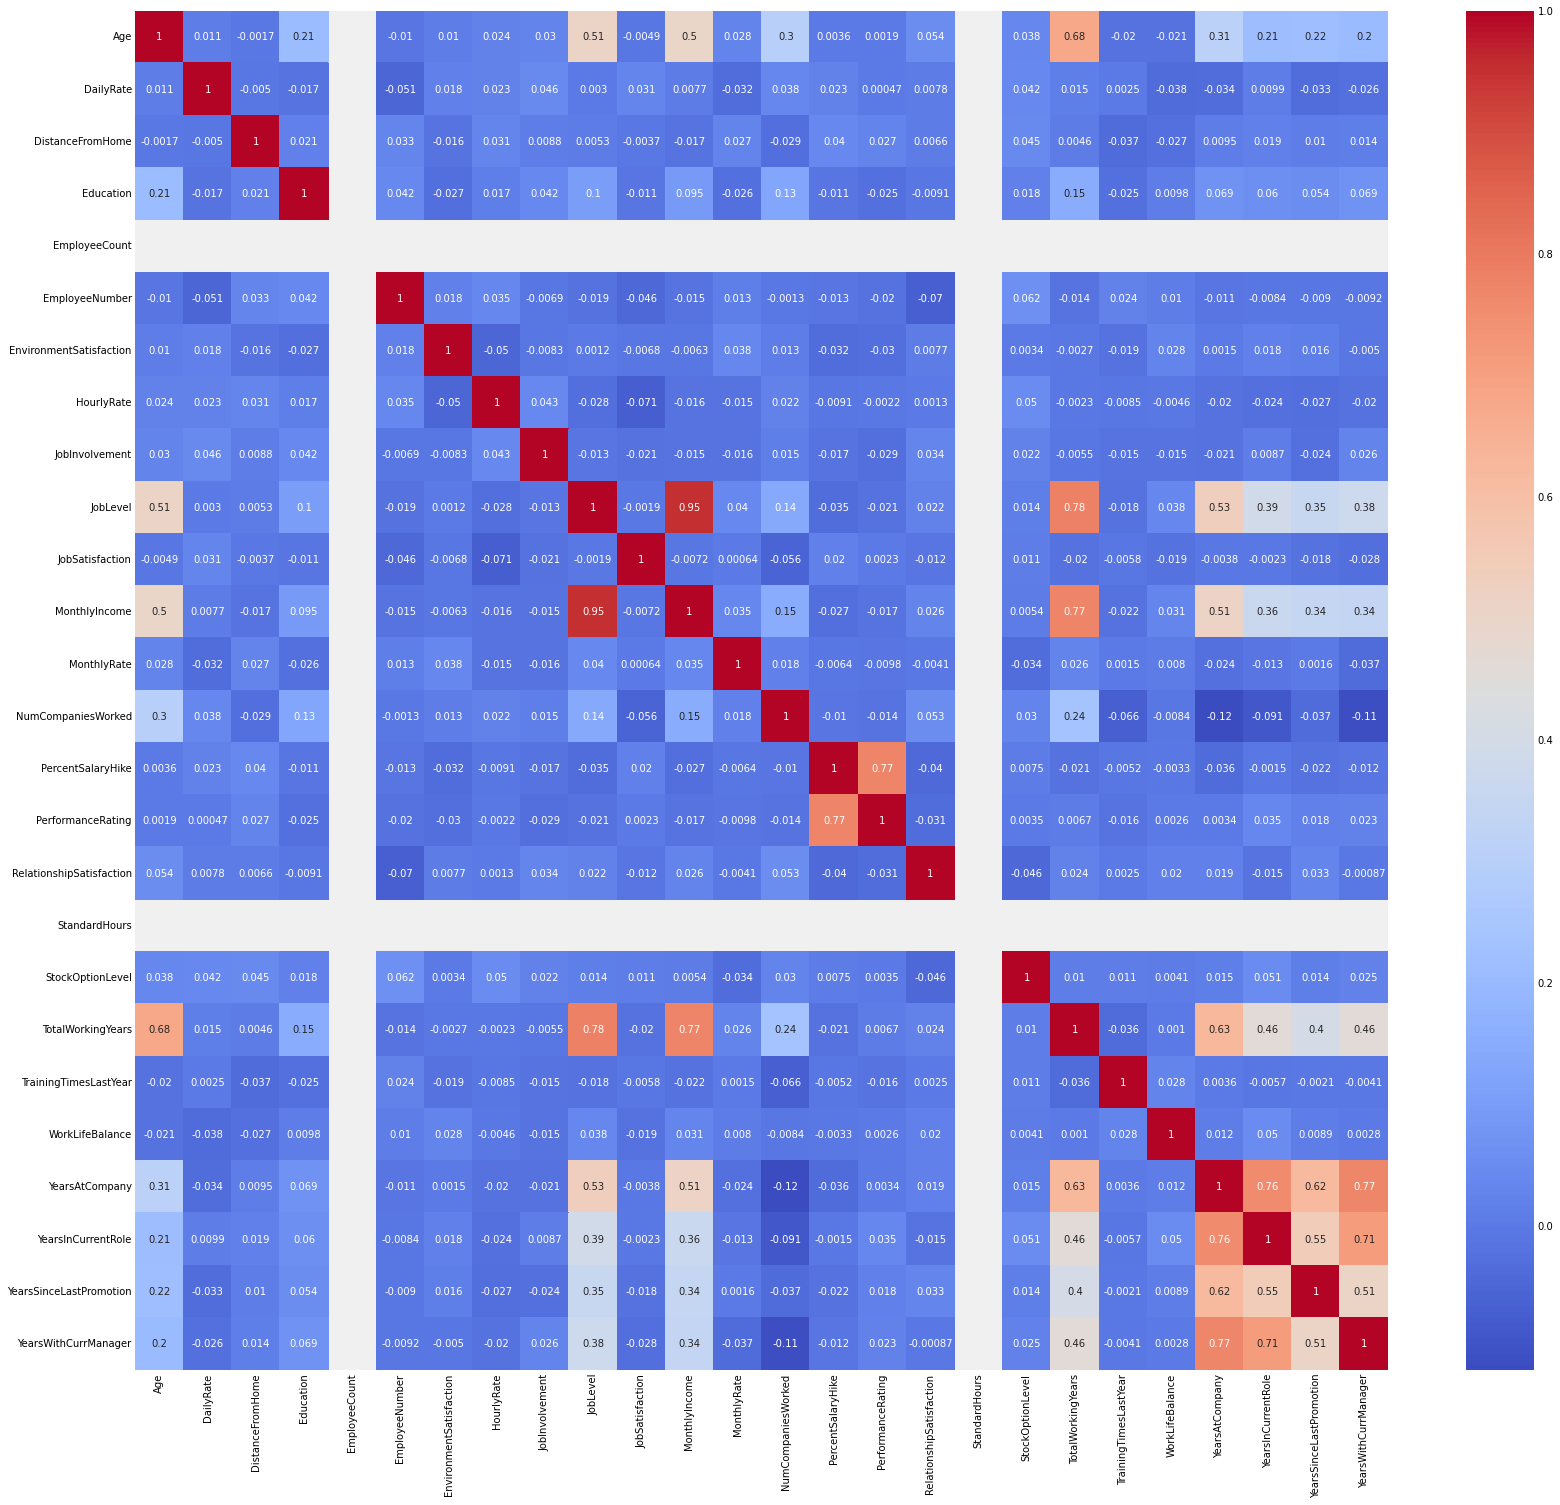

In [106]:
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(ibm_df.corr(), annot=True, cmap='coolwarm');

In [107]:
def create_barplot(df, column):
    f, axe = plt.subplots(figsize=(10,6))
    sns.countplot(x = df[column], hue=df['Attrition'], data=df)
    axe.set(xlabel = column, ylabel = 'Count')

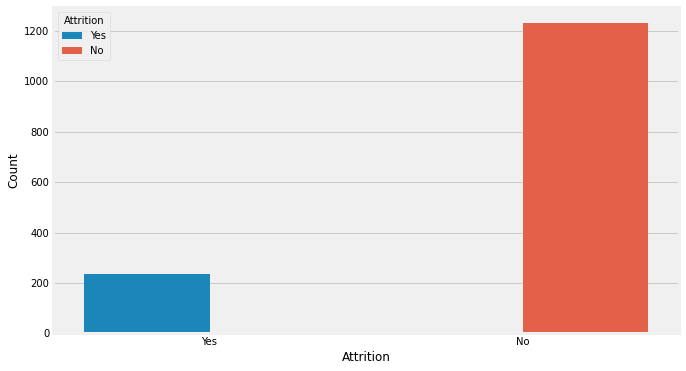

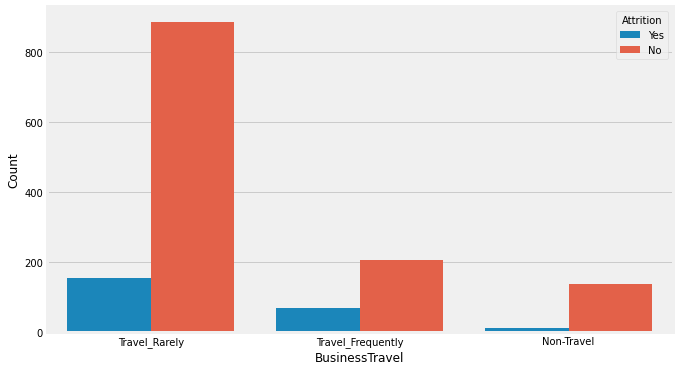

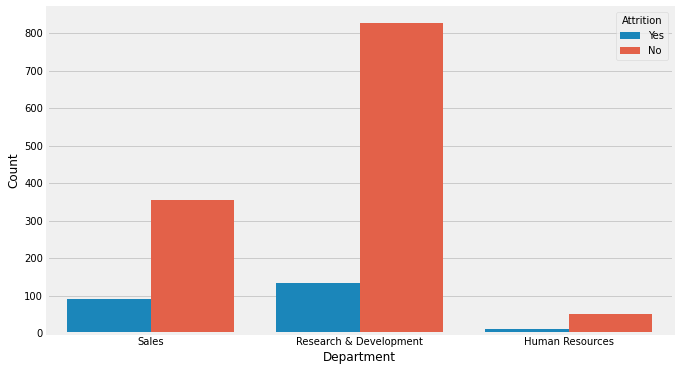

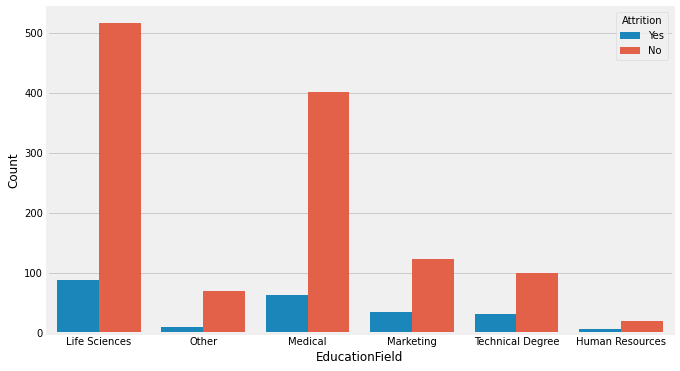

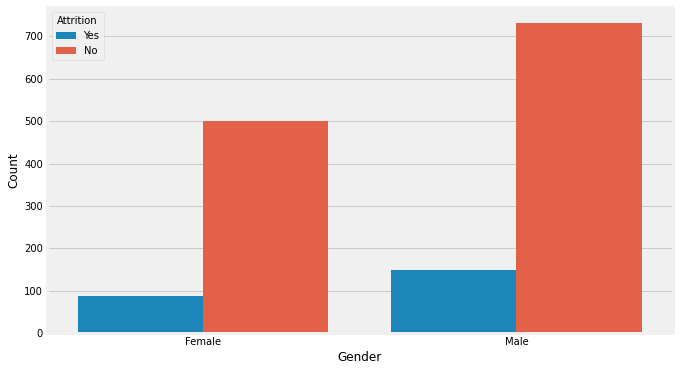

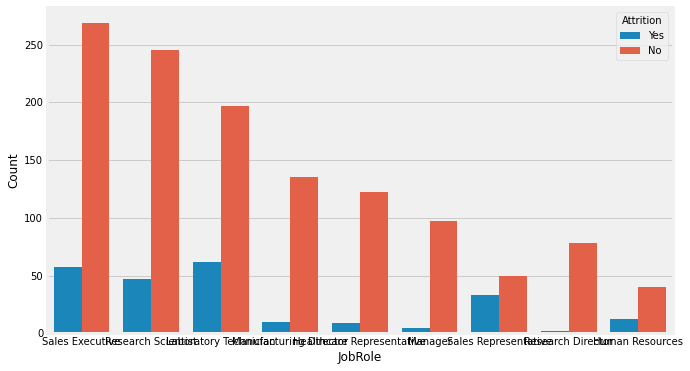

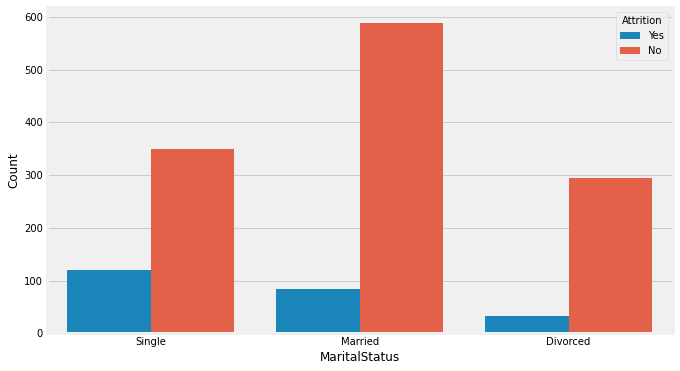

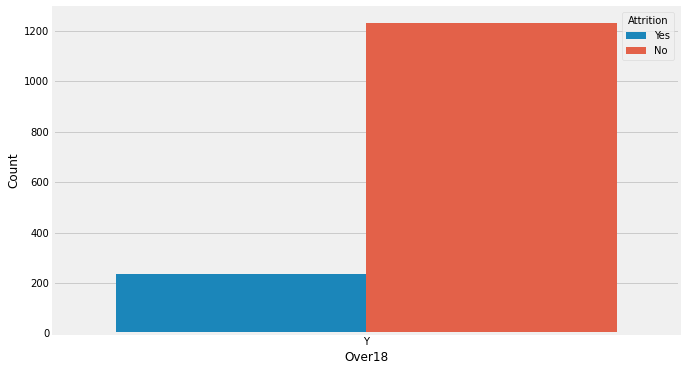

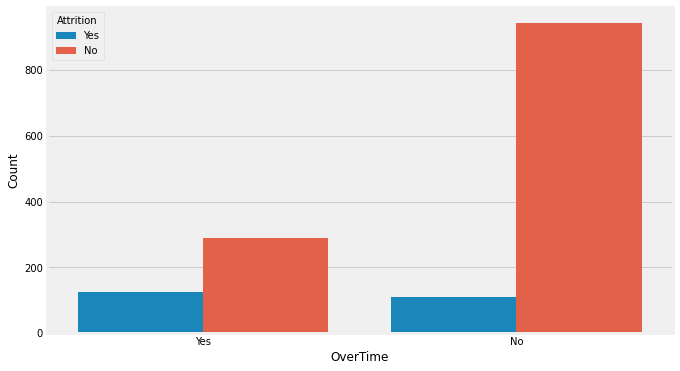

In [108]:
for column in cat_columns:
    create_barplot(ibm_df, column)

#Model Building

In [109]:
#setting parameters for training models
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [110]:
xgb_data = ibm_df.copy()
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_data = pd.concat([xgb_dummy, xgb_data], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

**Using XGBOOST Algorithm**

In [111]:
y_df = xgb_data['Attrition'].reset_index(drop=True)
x_df = xgb_data.drop(columns='Attrition')
#splitting dataset for training and testing
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def xgb_objective(space, early_stopping_rounds=50):
    
    model = XGBClassifier(
        learning_rate = space['learning_rate'], 
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        min_child_weight = space['m_child_weight'], 
        gamma = space['gamma'], 
        subsample = space['subsample'], 
        colsample_bytree = space['colsample_bytree'],
        objective = 'binary:logistic'
    )

    xgbfit_model = model.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              eval_metric = 'auc',
              early_stopping_rounds = early_stopping_rounds,
              verbose = False)
    
    predictions = model.predict(test_x)
    test_preds = model.predict_proba(test_x)[:,1]
    train_preds = model.predict_proba(train_x)[:,1]
    
    xgb_booster = model.get_booster()
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    #saving model as .json file
    xgbfit_model.save_model('xgboost_model.json')

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

In [112]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

trials = Trials()
xgb_hyperparams = fmin(fn = xgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
display(xgb_results)

100%|██████████| 150/150 [00:52<00:00,  2.87it/s, best loss: 0.14027272727272733]


{'model': 'XGBoost',
 'parameter search time': '0:00:52.286000',
 'accuracy': 0.905,
 'test auc score': 0.86,
 'training auc score': 0.887,
 'parameters': {'colsample_bytree': 0.9,
  'gamma': 0.5,
  'learning_rate': 0.2955852394977498,
  'm_child_weight': 1.0,
  'max_depth': 1.0,
  'n_estimators': 825.0,
  'subsample': 0.55}}

**Using LightBoost Algorithm**

In [129]:
lgb_data = ibm_df.copy()
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)
lgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

y_df = lgb_data['Attrition'].reset_index(drop=True)
x_df = lgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def lgb_objective(space, early_stopping_rounds=50):
    
    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']), 
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )
    
    lgbfit_model = lgbm.fit(train_x, train_y, 
            eval_set = [(train_x, train_y), (test_x, test_y)],
            early_stopping_rounds = early_stopping_rounds,
            eval_metric = 'auc',
            verbose = False)
    
    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(train_x)[:,1]
    
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

100%|██████████| 150/150 [00:21<00:00,  7.14it/s, best loss: 0.15497896213183726]


{'model': 'LightGBM',
 'parameter search time': '0:00:20.997000',
 'accuracy': 0.884,
 'test auc score': 0.845,
 'training auc score': 0.901,
 'parameters': {'colsample_bytree': 0.9771021172566791,
  'feature_fraction': 0.4011455339314631,
  'learning_rate': 0.2925841257285886,
  'max_depth': 1.0,
  'min_split_gain': 0.00924321843317483,
  'n_estimators': 1200.0,
  'num_leaves': 101.0,
  'reg_alpha': 0.9855173887523783,
  'reg_lambda': 0.5643366974401307}}

**Using CatBoost Algorithm**

In [130]:
cbo_data = ibm_df.copy()

for cat in categorical:
    cbo_data[cat] = cbo_data[cat].astype('category').cat.codes

y_df = cbo_data['Attrition'].reset_index(drop=True)
x_df = cbo_data.drop(columns='Attrition')

cboost_cat = categorical[1:]
#splitting dataset for training and testing
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)
cat_dims = [train_x.columns.get_loc(name) for name in cboost_cat]     
    
def cat_objective(space, early_stopping_rounds=30):
    
    cboost = CatBoostClassifier(
    eval_metric  = 'AUC', 
    learning_rate = space['learning_rate'],
    iterations = space['iterations'],
    depth = space['depth'],
    l2_leaf_reg = space['l2_leaf_reg'],
    border_count = space['border_count']
    )
    
    cbfit_model = cboost.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              early_stopping_rounds = early_stopping_rounds,
              cat_features = cat_dims, 
              verbose = False)
    
    predictions = cboost.predict(test_x)
    test_preds = cboost.predict_proba(test_x)[:,1]
    train_preds = cboost.predict_proba(train_x)[:,1]    

    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    #saving model as .json file
    cbfit_model.save_model('cb_model.json')
    
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc}
    
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'iterations': hp.quniform('iterations', 25, 1000, 25),
    'depth': hp.quniform('depth', 1, 16, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5), 
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cboost_hyperparams = fmin(fn = cat_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
display(cbo_results)

100%|██████████| 150/150 [12:31<00:00,  5.01s/it, best loss: 0.06425702811244971]


{'model': 'CatBoost',
 'parameter search time': '0:12:31.747000',
 'accuracy': 0.898,
 'test auc score': 0.936,
 'training auc score': 0.953,
 'parameters': {'border_count': 125.0,
  'depth': 2.0,
  'iterations': 600.0,
  'l2_leaf_reg': 2.0,
  'learning_rate': 0.22739778457309093}}

In [131]:
#printing datafram for the experiment result
final_results = pd.DataFrame([xgb_results, lgb_results, cbo_results])
display(final_results)

,model,parameter search time,accuracy,test auc score,training auc score,parameters
0,XGBoost,0:00:52.286000,0.905,0.860,0.887,"{'colsample_bytree': 0.9, 'gamma': 0.5, 'learn..."
1,LightGBM,0:00:20.997000,0.884,0.845,0.901,"{'colsample_bytree': 0.9771021172566791, 'feat..."
2,CatBoost,0:12:31.747000,0.898,0.936,0.953,"{'border_count': 125.0, 'depth': 2.0, 'iterati..."
